In [1]:
import warnings

import gym
import numpy as np
import pandas as pd
import requests
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnvWrapper
from stable_baselines3.common.evaluation import evaluate_policy

from gym_trading.envs.data_loader import PandasAssetChartDataLoader
from gym_trading.envs.exchange import BaseExchange
from gym_trading.envs.renderer import PlotRenderer
from gym_trading.envs.rewards import ProfitRewarder
from gym_trading.envs.action_space import BudgetAllocationSpace

from abc import ABC, abstractmethod

# Hide all warnings
warnings.filterwarnings("ignore")

In [2]:
def get_symbol_history(symbol, n_days):
    url = f'https://api.coingecko.com/api/v3/coins/{symbol}/market_chart'
    params = {
        'vs_currency': 'usd',
        'days': str(n_days),
    }
    response = requests.get(url, params=params)
    data = response.json()

    # Extract dates and prices from the API response
    timestamps = data['prices']
    dates = [pd.to_datetime(timestamp, unit='ms') for timestamp, _ in timestamps]
    prices = [price for _, price in timestamps]
    market_caps = [market_cap for _, market_cap in data['market_caps']]
    total_volumes = [total_volume for _, total_volume in data['total_volumes']]
    
    print(f'{symbol.upper()}: {len(dates) = }, {len(prices) = }, {len(market_caps) = }, {len(total_volumes) = }')

    return pd.DataFrame({
        'Date': dates,
        'Price': prices,
        'Market Cap': market_caps,
        'Total Volume': total_volumes
    })

BITCOIN: len(dates) = 1081, len(prices) = 1081, len(market_caps) = 1081, len(total_volumes) = 1081
ETHEREUM: len(dates) = 1081, len(prices) = 1081, len(market_caps) = 1081, len(total_volumes) = 1081
LITECOIN: len(dates) = 1081, len(prices) = 1081, len(market_caps) = 1081, len(total_volumes) = 1081
RIPPLE: len(dates) = 1081, len(prices) = 1081, len(market_caps) = 1081, len(total_volumes) = 1081


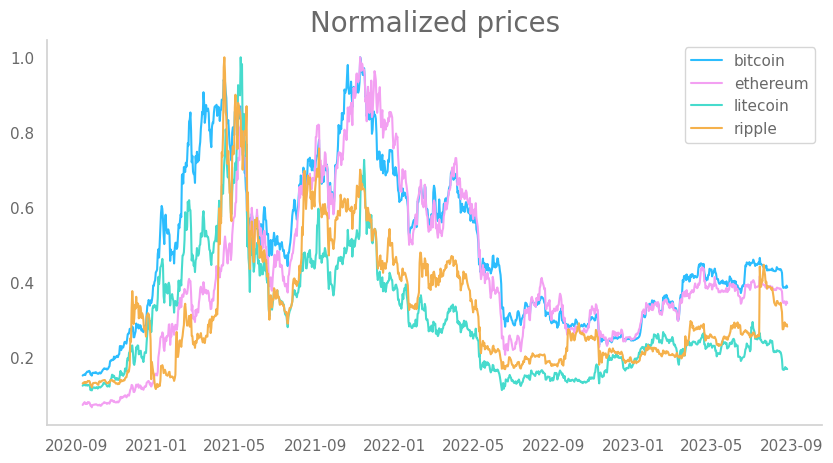

In [3]:
N_DAYS = 360 * 3

SYMBOLS = [
    'bitcoin', 
    'ethereum', 
    'litecoin',
    'ripple'
]
datasets = {}

df = pd.DataFrame()

for symbol in SYMBOLS:
    df = get_symbol_history(symbol, N_DAYS)

    # removing the last row since someimes are not aligned
    df.drop(df.index[-1], inplace=True)

    plt.plot(df['Date'], df['Price'] / np.max(df['Price']), label=symbol)
    datasets[symbol] = df

plt.title('Normalized prices')
plt.legend()
plt.show()

In [4]:
def train_valid_test_df(df, split_rate=0.2):
    train_df, test_df = train_test_split(df, test_size=split_rate, shuffle=False)
    train_df, valid_df = train_test_split(train_df, test_size=split_rate, shuffle=False)
    return train_df, valid_df, test_df

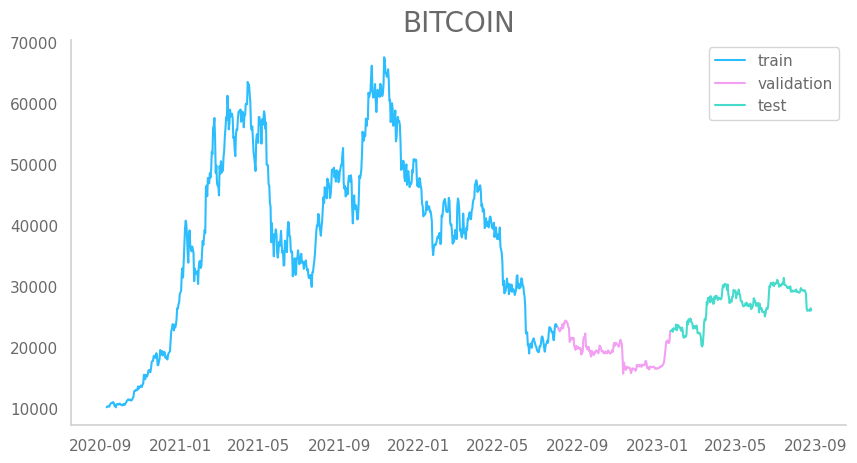

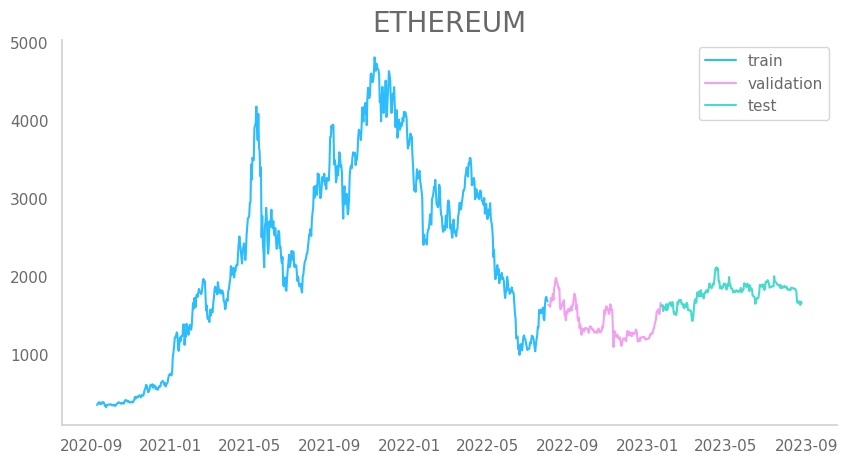

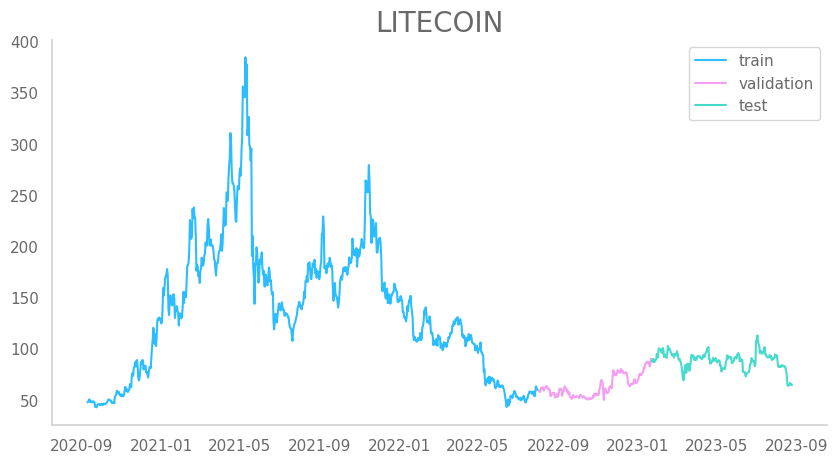

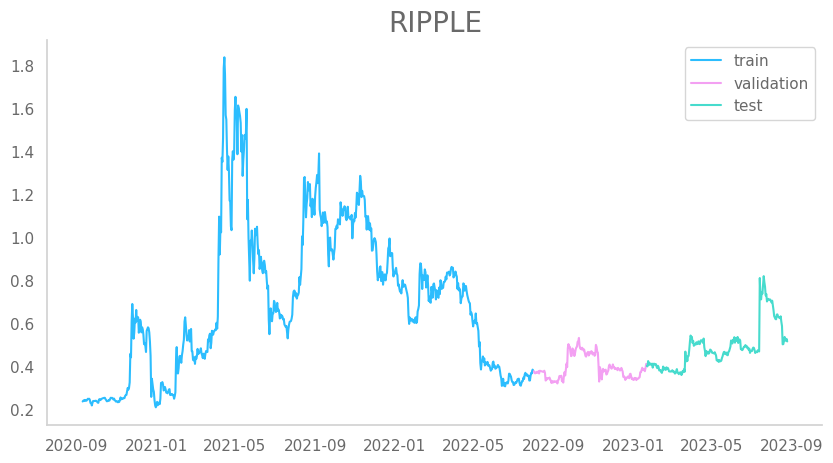

In [5]:
split_datasets = {}
for symbol, df in datasets.items():
    split_datasets[symbol] = train_valid_test_df(df)

    plt.plot(split_datasets[symbol][0]['Date'], split_datasets[symbol][0]['Price'], label=f'train')
    plt.plot(split_datasets[symbol][1]['Date'], split_datasets[symbol][1]['Price'], label=f'validation')
    plt.plot(split_datasets[symbol][2]['Date'], split_datasets[symbol][2]['Price'], label=f'test')

    plt.title(symbol.upper())
    plt.legend()
    plt.show()

In [6]:
# split_datasets[SYMBOLS[0]][0].describe()
# split_datasets[SYMBOLS[0]][1].describe()
# split_datasets[SYMBOLS[0]][2].describe()

In [7]:
INIT_LIQUIDITY = 100.0
BUY_FEE = 0.1
SELL_FEE = 0.1

# TRAIN ENV
train_data_loader = PandasAssetChartDataLoader(
    datasets={symbol: split[0] for symbol, split in split_datasets.items()},
    timestamp_column_name='Date',
    price_column_name='Price'
)
train_env = gym.make(
    'gym_trading:trading-v0',
    data_loader=train_data_loader,
    exchange=BaseExchange(train_data_loader, init_liquidity=INIT_LIQUIDITY, buy_fee=BUY_FEE, sell_fee=SELL_FEE),
    rewarder=ProfitRewarder(),
    renderer=PlotRenderer(),
)

# VALID ENV
valid_data_loader = PandasAssetChartDataLoader(
    datasets={symbol: split[1] for symbol, split in split_datasets.items()},
    timestamp_column_name='Date',
    price_column_name='Price'
)
valid_env = gym.make(
    'gym_trading:trading-v0',
    data_loader=valid_data_loader,
    exchange=BaseExchange(valid_data_loader, init_liquidity=INIT_LIQUIDITY, buy_fee=BUY_FEE, sell_fee=SELL_FEE),
    rewarder=ProfitRewarder(),
    renderer=PlotRenderer(),
)

# TEST ENV
test_data_loader = PandasAssetChartDataLoader(
    datasets={symbol: split[2] for symbol, split in split_datasets.items()},
    timestamp_column_name='Date',
    price_column_name='Price'
)
test_env = gym.make(
    'gym_trading:trading-v0',
    data_loader=test_data_loader,
    exchange=BaseExchange(test_data_loader, init_liquidity=INIT_LIQUIDITY, buy_fee=BUY_FEE, sell_fee=SELL_FEE),
    rewarder=ProfitRewarder(),
    renderer=PlotRenderer(),
)

In [8]:
observation = train_env.reset()
observation

array([[1.0230154e+04, 1.8875793e+11, 2.1357083e+10, 3.5123227e+02,
        3.9580369e+10, 1.3120851e+10, 4.7803539e+01, 3.1274268e+09,
        1.8778779e+09, 2.3911661e-01, 1.0762935e+10, 1.6646346e+09]],
      dtype=float32)

In [9]:
observation.shape

(1, 12)

In [10]:
class Agent(ABC):

    @abstractmethod
    def action(self, observation: np.ndarray) -> np.ndarray:
        pass

In [11]:
def simulate(agent: Agent, env, render=False):
    print('Simulating a trading session with agent:', agent.__class__.__name__)
    observation = env.reset()[0]
    
    done = False
    while not done:
        action = agent.action(observation)
        observation, reward, done, _ = env.step(action)
        
    if render:
        env.render()
        
    return reward

In [12]:
class RandomAgent(Agent):
    
    def action(self, observation: np.ndarray) -> np.ndarray:
        return BudgetAllocationSpace(len(SYMBOLS)).sample()
    
class UniformAgent(Agent):

    def action(self, observation: np.ndarray) -> np.ndarray:
        return np.ones(len(SYMBOLS)) / len(split_datasets.keys())

Simulating a trading session with agent: RandomAgent


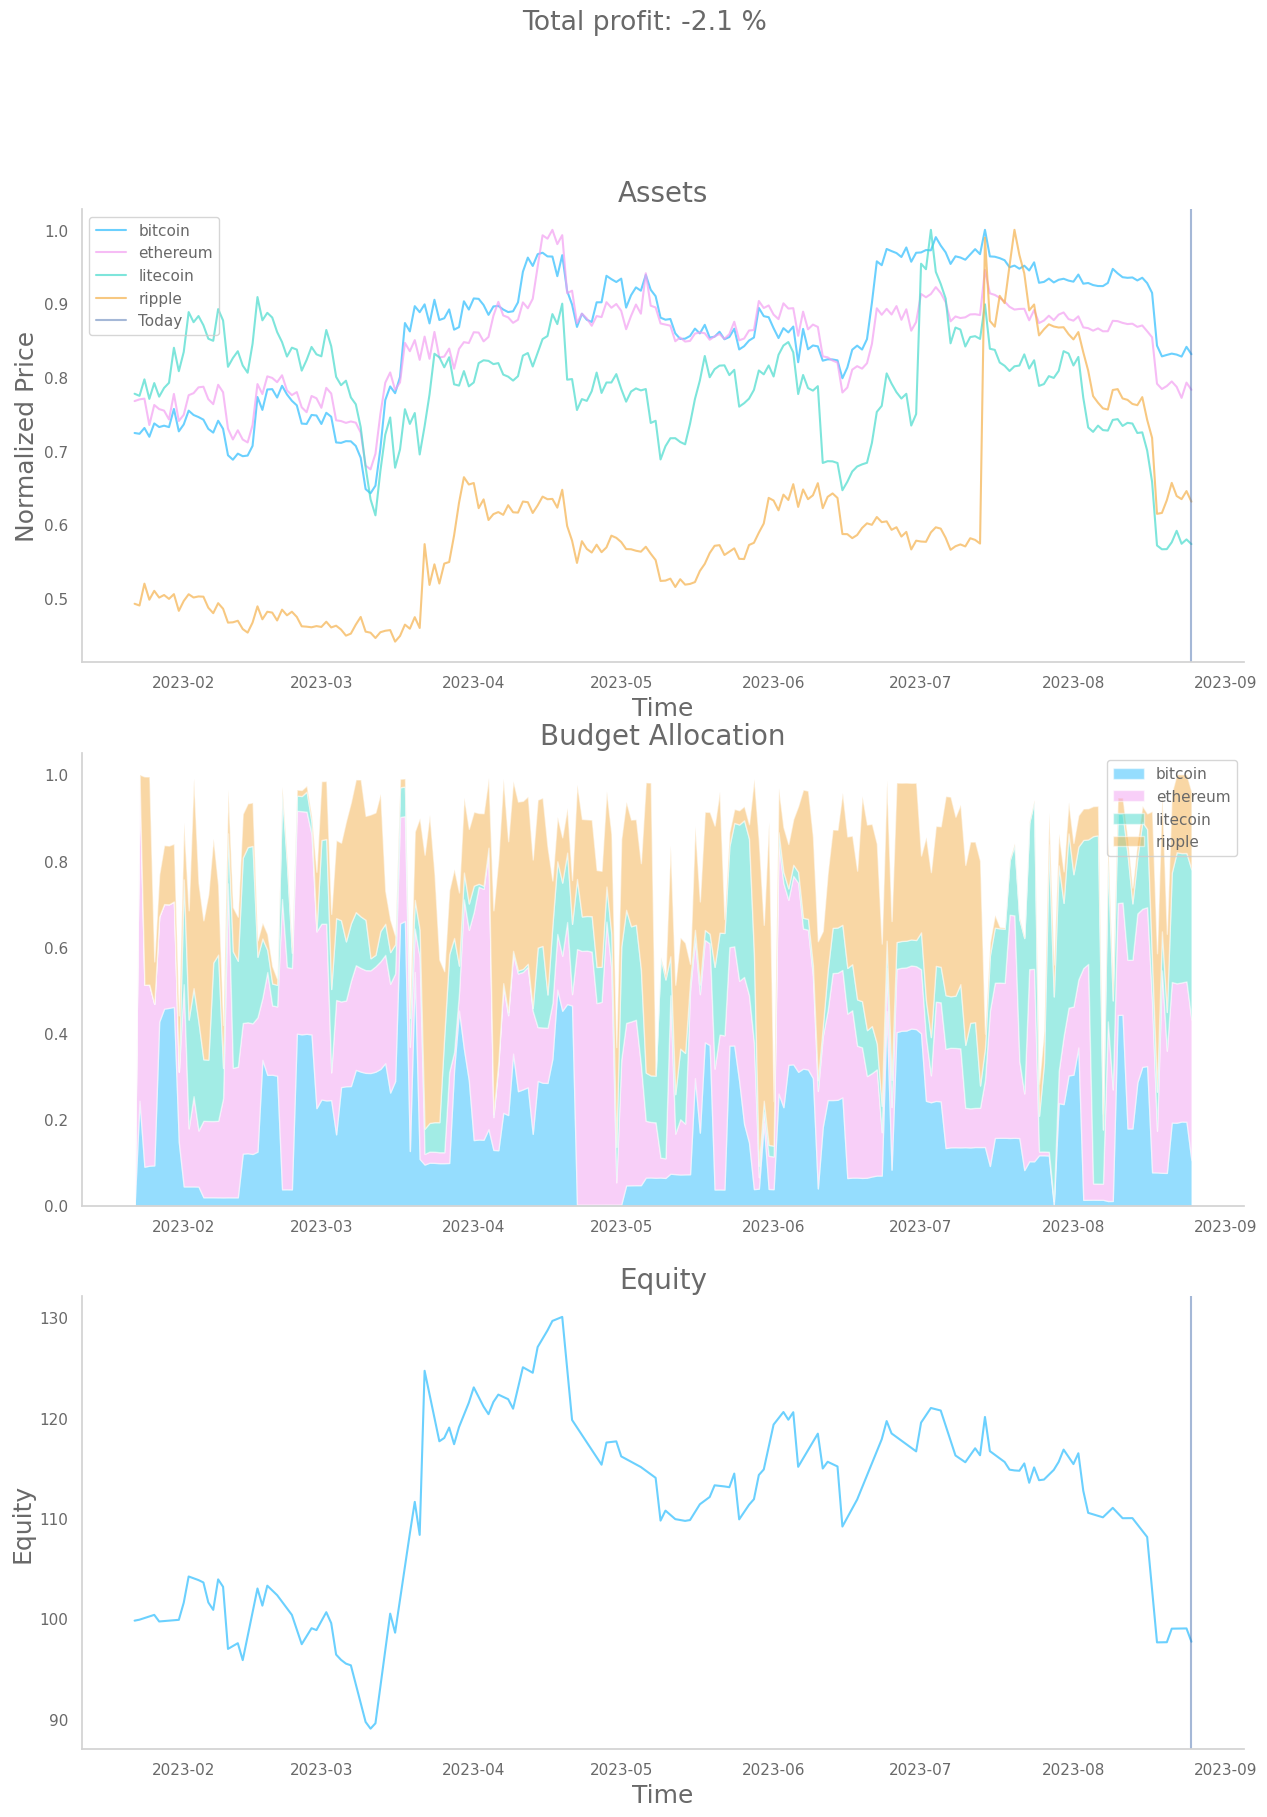

-2.1015332096311568

In [13]:
simulate(RandomAgent(), test_env, render=True)

Simulating a trading session with agent: UniformAgent


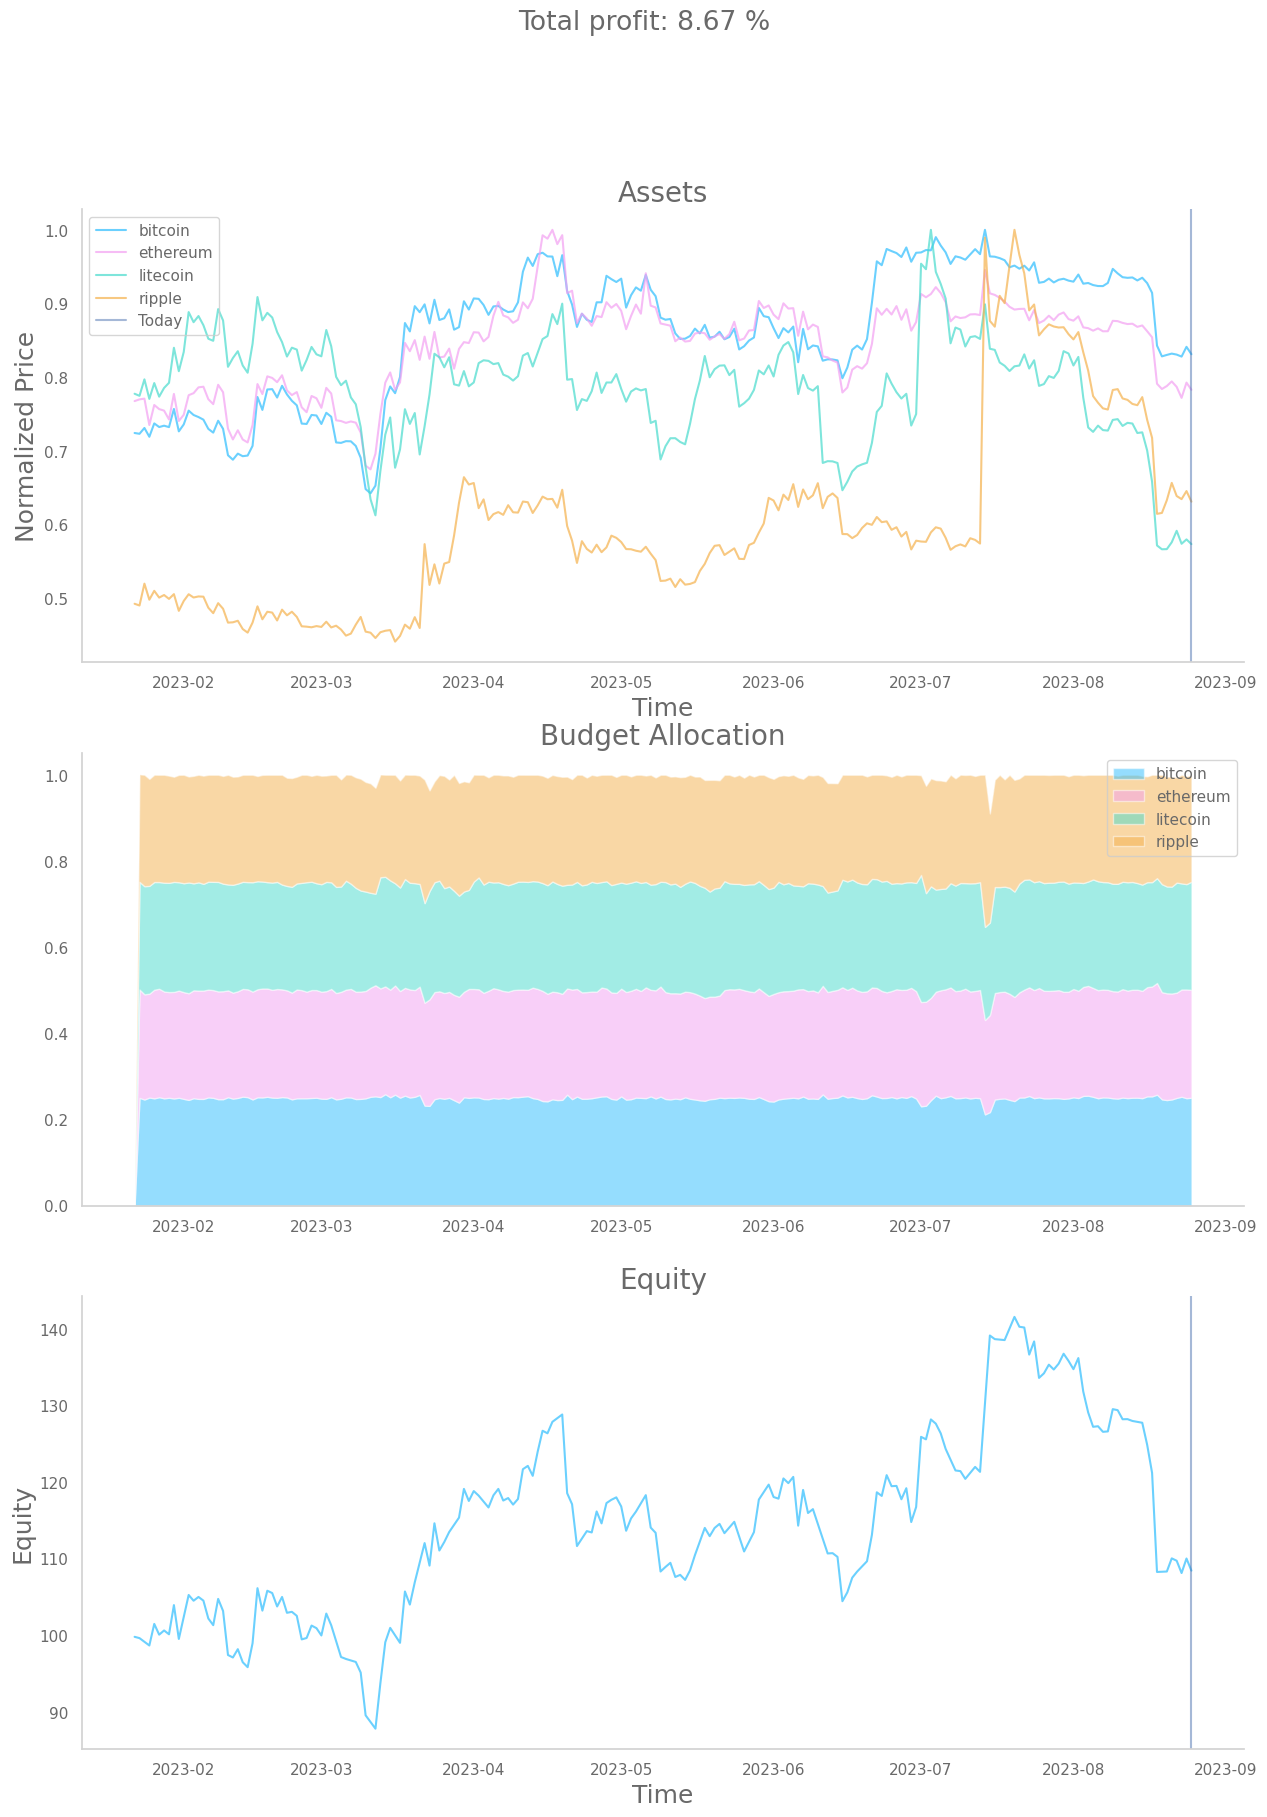

8.665592121931475

In [14]:
simulate(UniformAgent(), test_env, render=True)

In [15]:
class ObservationPreprocessWrapper(VecEnvWrapper):
    def __init__(self, venv):
        super(ObservationPreprocessWrapper, self).__init__(venv)

    def reset(self):
        obs = self.venv.reset()
        preprocessed_obs = self._preprocess(obs)
        return preprocessed_obs

    def step_wait(self):
        obs, rew, done, info = self.venv.step_wait()
        preprocessed_obs = self._preprocess(obs)
        return preprocessed_obs, rew, done, info

    @staticmethod
    def _preprocess(obs):
        scaled_obs = StandardScaler().fit_transform(obs)
        return scaled_obs

In [16]:
# Creating and wrapping the environments
train_vec_env = DummyVecEnv([lambda: train_env])
train_vec_env = ObservationPreprocessWrapper(train_vec_env)

valid_vec_env = DummyVecEnv([lambda: valid_env])
valid_vec_env = ObservationPreprocessWrapper(valid_vec_env)

test_vec_env = DummyVecEnv([lambda: test_env])
test_vec_env = ObservationPreprocessWrapper(test_vec_env)

In [17]:
def evaluate(model, env):
    mean_reward, _ = evaluate_policy(
        model, 
        env, 
        n_eval_episodes=1,
        deterministic=True,
        render=True
    )
    print(f"Mean reward: {mean_reward:.2f}")

In [18]:
log_dir = './logs/'
time_steps = 500_000

model = PPO(
    policy="MlpPolicy",
    env=train_vec_env,
    verbose=1,
    tensorboard_log=log_dir,
)

Using cuda device


In [19]:
print('Evaluate on test vec env before training')
evaluate(model, test_vec_env)

Evaluate on test vec env before training
Mean reward: 0.00


In [20]:
eval_callback = EvalCallback(
    eval_env=valid_vec_env,
    best_model_save_path='./models',
    log_path=log_dir,
    eval_freq=1000,
    n_eval_episodes=1,
    deterministic=True,
    render=False
)

callbacks = [eval_callback]

model.learn(
    total_timesteps=time_steps,
    callback=callbacks,
    progress_bar=True
)

Logging to ./logs/PPO_3


Output()

Eval num_timesteps=1000, episode_reward=0.00 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 0        |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------


New best mean reward!

Eval num_timesteps=2000, episode_reward=0.00 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 0        |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
-----------------------------
| time/              |      |
|    fps             | 73   |
|    iterations      | 1    |
|    time_elapsed    | 27   |
|    total_timesteps | 2048 |
-----------------------------


Eval num_timesteps=3000, episode_reward=-16.71 +/- 0.00

Episode length: 173.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 173          |
|    mean_reward          | -16.7        |
| time/                   |              |
|    total_timesteps      | 3000         |
| train/                  |              |
|    approx_kl            | 7.730952e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.68        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 3.87e+06     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000337    |
|    std                  | 1            |
|    value_loss           | 7.23e+06     |
------------------------------------------


Eval num_timesteps=4000, episode_reward=-16.71 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | -16.7    |
| time/              |          |
|    total_timesteps | 4000     |
---------------------------------
-----------------------------
| time/              |      |
|    fps             | 73   |
|    iterations      | 2    |
|    time_elapsed    | 55   |
|    total_timesteps | 4096 |
-----------------------------


Eval num_timesteps=5000, episode_reward=0.00 +/- 0.00

Episode length: 173.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 173          |
|    mean_reward          | 0            |
| time/                   |              |
|    total_timesteps      | 5000         |
| train/                  |              |
|    approx_kl            | 0.0002783973 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.68        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.19e+06     |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.000759    |
|    std                  | 0.999        |
|    value_loss           | 2.51e+06     |
------------------------------------------


Eval num_timesteps=6000, episode_reward=0.00 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 0        |
| time/              |          |
|    total_timesteps | 6000     |
---------------------------------
-----------------------------
| time/              |      |
|    fps             | 73   |
|    iterations      | 3    |
|    time_elapsed    | 83   |
|    total_timesteps | 6144 |
-----------------------------


Eval num_timesteps=7000, episode_reward=6.96 +/- 0.00

Episode length: 173.00 +/- 0.00

--------------------------------------------
| eval/                   |                |
|    mean_ep_length       | 173            |
|    mean_reward          | 6.96           |
| time/                   |                |
|    total_timesteps      | 7000           |
| train/                  |                |
|    approx_kl            | 0.000111769885 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -5.67          |
|    explained_variance   | -1.19e-07      |
|    learning_rate        | 0.0003         |
|    loss                 | 3.48e+06       |
|    n_updates            | 30             |
|    policy_gradient_loss | -0.000568      |
|    std                  | 0.997          |
|    value_loss           | 7.65e+06       |
--------------------------------------------


New best mean reward!

Eval num_timesteps=8000, episode_reward=6.96 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 6.96     |
| time/              |          |
|    total_timesteps | 8000     |
---------------------------------
-----------------------------
| time/              |      |
|    fps             | 73   |
|    iterations      | 4    |
|    time_elapsed    | 111  |
|    total_timesteps | 8192 |
-----------------------------


Eval num_timesteps=9000, episode_reward=10.18 +/- 0.00

Episode length: 173.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 173          |
|    mean_reward          | 10.2         |
| time/                   |              |
|    total_timesteps      | 9000         |
| train/                  |              |
|    approx_kl            | 6.758241e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.67        |
|    explained_variance   | 1.79e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.14e+07     |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.000339    |
|    std                  | 0.999        |
|    value_loss           | 2.17e+07     |
------------------------------------------


New best mean reward!

Eval num_timesteps=10000, episode_reward=10.18 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 10.2     |
| time/              |          |
|    total_timesteps | 10000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 73    |
|    iterations      | 5     |
|    time_elapsed    | 139   |
|    total_timesteps | 10240 |
------------------------------


Eval num_timesteps=11000, episode_reward=11.28 +/- 0.00

Episode length: 173.00 +/- 0.00

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 173           |
|    mean_reward          | 11.3          |
| time/                   |               |
|    total_timesteps      | 11000         |
| train/                  |               |
|    approx_kl            | 1.7301296e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.67         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.41e+07      |
|    n_updates            | 50            |
|    policy_gradient_loss | -7.62e-05     |
|    std                  | 0.998         |
|    value_loss           | 2.55e+07      |
-------------------------------------------


New best mean reward!

Eval num_timesteps=12000, episode_reward=11.28 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 11.3     |
| time/              |          |
|    total_timesteps | 12000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 73    |
|    iterations      | 6     |
|    time_elapsed    | 167   |
|    total_timesteps | 12288 |
------------------------------


Eval num_timesteps=13000, episode_reward=11.52 +/- 0.00

Episode length: 173.00 +/- 0.00

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 173           |
|    mean_reward          | 11.5          |
| time/                   |               |
|    total_timesteps      | 13000         |
| train/                  |               |
|    approx_kl            | 1.8996536e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.67         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 7.2e+06       |
|    n_updates            | 60            |
|    policy_gradient_loss | -9.48e-05     |
|    std                  | 0.999         |
|    value_loss           | 1.53e+07      |
-------------------------------------------


New best mean reward!

Eval num_timesteps=14000, episode_reward=11.52 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 11.5     |
| time/              |          |
|    total_timesteps | 14000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 72    |
|    iterations      | 7     |
|    time_elapsed    | 196   |
|    total_timesteps | 14336 |
------------------------------


Eval num_timesteps=15000, episode_reward=7.77 +/- 0.00

Episode length: 173.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 173          |
|    mean_reward          | 7.77         |
| time/                   |              |
|    total_timesteps      | 15000        |
| train/                  |              |
|    approx_kl            | 4.909755e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.67        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 4.45e+06     |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.000136    |
|    std                  | 0.999        |
|    value_loss           | 1.08e+07     |
------------------------------------------


Eval num_timesteps=16000, episode_reward=7.77 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 7.77     |
| time/              |          |
|    total_timesteps | 16000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 72    |
|    iterations      | 8     |
|    time_elapsed    | 224   |
|    total_timesteps | 16384 |
------------------------------


Eval num_timesteps=17000, episode_reward=8.92 +/- 0.00

Episode length: 173.00 +/- 0.00

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 173           |
|    mean_reward          | 8.92          |
| time/                   |               |
|    total_timesteps      | 17000         |
| train/                  |               |
|    approx_kl            | 9.0026704e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.68         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 3.51e+06      |
|    n_updates            | 80            |
|    policy_gradient_loss | -0.00027      |
|    std                  | 1             |
|    value_loss           | 6.87e+06      |
-------------------------------------------


Eval num_timesteps=18000, episode_reward=8.92 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 8.92     |
| time/              |          |
|    total_timesteps | 18000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 72    |
|    iterations      | 9     |
|    time_elapsed    | 253   |
|    total_timesteps | 18432 |
------------------------------


Eval num_timesteps=19000, episode_reward=5.85 +/- 0.00

Episode length: 173.00 +/- 0.00

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 173           |
|    mean_reward          | 5.85          |
| time/                   |               |
|    total_timesteps      | 19000         |
| train/                  |               |
|    approx_kl            | 1.0355172e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.68         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 2.65e+07      |
|    n_updates            | 90            |
|    policy_gradient_loss | -6.27e-05     |
|    std                  | 1             |
|    value_loss           | 4.04e+07      |
-------------------------------------------


Eval num_timesteps=20000, episode_reward=5.85 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 5.85     |
| time/              |          |
|    total_timesteps | 20000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 72    |
|    iterations      | 10    |
|    time_elapsed    | 281   |
|    total_timesteps | 20480 |
------------------------------


Eval num_timesteps=21000, episode_reward=5.41 +/- 0.00

Episode length: 173.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 173          |
|    mean_reward          | 5.41         |
| time/                   |              |
|    total_timesteps      | 21000        |
| train/                  |              |
|    approx_kl            | 6.698139e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.68        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.57e+07     |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.000367    |
|    std                  | 1            |
|    value_loss           | 2.63e+07     |
------------------------------------------


Eval num_timesteps=22000, episode_reward=5.41 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 5.41     |
| time/              |          |
|    total_timesteps | 22000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 72    |
|    iterations      | 11    |
|    time_elapsed    | 309   |
|    total_timesteps | 22528 |
------------------------------


Eval num_timesteps=23000, episode_reward=21.80 +/- 0.00

Episode length: 173.00 +/- 0.00

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 173           |
|    mean_reward          | 21.8          |
| time/                   |               |
|    total_timesteps      | 23000         |
| train/                  |               |
|    approx_kl            | 0.00026304103 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.67         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.31e+06      |
|    n_updates            | 110           |
|    policy_gradient_loss | -0.000569     |
|    std                  | 0.999         |
|    value_loss           | 4.59e+06      |
-------------------------------------------


New best mean reward!

Eval num_timesteps=24000, episode_reward=21.80 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 21.8     |
| time/              |          |
|    total_timesteps | 24000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 72    |
|    iterations      | 12    |
|    time_elapsed    | 337   |
|    total_timesteps | 24576 |
------------------------------


Eval num_timesteps=25000, episode_reward=1.75 +/- 0.00

Episode length: 173.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 173          |
|    mean_reward          | 1.75         |
| time/                   |              |
|    total_timesteps      | 25000        |
| train/                  |              |
|    approx_kl            | 0.0006838498 |
|    clip_fraction        | 0.000537     |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.69        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 5.36e+05     |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.000898    |
|    std                  | 1.01         |
|    value_loss           | 1.55e+06     |
------------------------------------------


Eval num_timesteps=26000, episode_reward=1.75 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 1.75     |
| time/              |          |
|    total_timesteps | 26000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 72    |
|    iterations      | 13    |
|    time_elapsed    | 366   |
|    total_timesteps | 26624 |
------------------------------


Eval num_timesteps=27000, episode_reward=0.00 +/- 0.00

Episode length: 173.00 +/- 0.00

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 173           |
|    mean_reward          | 0             |
| time/                   |               |
|    total_timesteps      | 27000         |
| train/                  |               |
|    approx_kl            | 0.00014130262 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.71         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.21e+06      |
|    n_updates            | 130           |
|    policy_gradient_loss | -0.000373     |
|    std                  | 1.01          |
|    value_loss           | 3.48e+06      |
-------------------------------------------


Eval num_timesteps=28000, episode_reward=0.00 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 0        |
| time/              |          |
|    total_timesteps | 28000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 72    |
|    iterations      | 14    |
|    time_elapsed    | 394   |
|    total_timesteps | 28672 |
------------------------------


Eval num_timesteps=29000, episode_reward=0.00 +/- 0.00

Episode length: 173.00 +/- 0.00

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 173           |
|    mean_reward          | 0             |
| time/                   |               |
|    total_timesteps      | 29000         |
| train/                  |               |
|    approx_kl            | 0.00023390126 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.72         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.98e+06      |
|    n_updates            | 140           |
|    policy_gradient_loss | -0.000642     |
|    std                  | 1.01          |
|    value_loss           | 3.49e+06      |
-------------------------------------------


Eval num_timesteps=30000, episode_reward=0.00 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 0        |
| time/              |          |
|    total_timesteps | 30000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 72    |
|    iterations      | 15    |
|    time_elapsed    | 423   |
|    total_timesteps | 30720 |
------------------------------


Eval num_timesteps=31000, episode_reward=0.00 +/- 0.00

Episode length: 173.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 173          |
|    mean_reward          | 0            |
| time/                   |              |
|    total_timesteps      | 31000        |
| train/                  |              |
|    approx_kl            | 8.830818e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.73        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 4.85e+06     |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.000385    |
|    std                  | 1.02         |
|    value_loss           | 7.52e+06     |
------------------------------------------


Eval num_timesteps=32000, episode_reward=0.00 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 0        |
| time/              |          |
|    total_timesteps | 32000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 72    |
|    iterations      | 16    |
|    time_elapsed    | 451   |
|    total_timesteps | 32768 |
------------------------------


Eval num_timesteps=33000, episode_reward=0.00 +/- 0.00

Episode length: 173.00 +/- 0.00

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 173           |
|    mean_reward          | 0             |
| time/                   |               |
|    total_timesteps      | 33000         |
| train/                  |               |
|    approx_kl            | 4.1695603e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.74         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 3.52e+06      |
|    n_updates            | 160           |
|    policy_gradient_loss | -0.000225     |
|    std                  | 1.01          |
|    value_loss           | 6.96e+06      |
-------------------------------------------


Eval num_timesteps=34000, episode_reward=0.00 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 0        |
| time/              |          |
|    total_timesteps | 34000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 72    |
|    iterations      | 17    |
|    time_elapsed    | 480   |
|    total_timesteps | 34816 |
------------------------------


Eval num_timesteps=35000, episode_reward=0.00 +/- 0.00

Episode length: 173.00 +/- 0.00

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 173           |
|    mean_reward          | 0             |
| time/                   |               |
|    total_timesteps      | 35000         |
| train/                  |               |
|    approx_kl            | 0.00017319288 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.73         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.73e+06      |
|    n_updates            | 170           |
|    policy_gradient_loss | -0.000517     |
|    std                  | 1.01          |
|    value_loss           | 3.74e+06      |
-------------------------------------------


Eval num_timesteps=36000, episode_reward=0.00 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 0        |
| time/              |          |
|    total_timesteps | 36000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 72    |
|    iterations      | 18    |
|    time_elapsed    | 509   |
|    total_timesteps | 36864 |
------------------------------


Eval num_timesteps=37000, episode_reward=0.00 +/- 0.00

Episode length: 173.00 +/- 0.00

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 173           |
|    mean_reward          | 0             |
| time/                   |               |
|    total_timesteps      | 37000         |
| train/                  |               |
|    approx_kl            | 4.6231493e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.73         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 5.42e+06      |
|    n_updates            | 180           |
|    policy_gradient_loss | -0.000197     |
|    std                  | 1.01          |
|    value_loss           | 9.17e+06      |
-------------------------------------------


Eval num_timesteps=38000, episode_reward=0.00 +/- 0.00

Episode length: 173.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 173      |
|    mean_reward     | 0        |
| time/              |          |
|    total_timesteps | 38000    |
---------------------------------
------------------------------
| time/              |       |
|    fps             | 72    |
|    iterations      | 19    |
|    time_elapsed    | 538   |
|    total_timesteps | 38912 |
------------------------------


Eval num_timesteps=39000, episode_reward=0.00 +/- 0.00

Episode length: 173.00 +/- 0.00

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 173           |
|    mean_reward          | 0             |
| time/                   |               |
|    total_timesteps      | 39000         |
| train/                  |               |
|    approx_kl            | 0.00019677388 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.73         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 3.03e+06      |
|    n_updates            | 190           |
|    policy_gradient_loss | -0.000659     |
|    std                  | 1.01          |
|    value_loss           | 6.23e+06      |
-------------------------------------------


KeyboardInterrupt: 

In [22]:
%load_ext tensorboard
%tensorboard --logdir ./logs/ --port 8090

The tensorboard extension is already loaded. To reload it, use:

%reload_ext tensorboard

In [ ]:
# class SB3Agent(Agent):
    
#     def __init__(self, model):
#         self.model = model

#     def action(self, observation: np.ndarray) -> np.ndarray:
#         return self.model.predict(observation, deterministic=True)[0].flatten()

In [ ]:
# best_model = PPO.load('./models/best_model.zip')

# simulate(SB3Agent(best_model), test_env, render=True)

In [23]:
best_model = PPO.load('./models/best_model.zip')

evaluate(best_model, test_vec_env)

Mean reward: 81.99